## Model 1: Showcase

- fit baseline model to period of April 2020 - end of November 2020, everything observed

In [31]:
from src.model import account_for_nans, _model, to_log_probs

In [32]:
import jax

jax.config.update("jax_enable_x64", True)

In [33]:
import pandas as pd
import jax.random as jrn
from jax import numpy as jnp, vmap
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.estimation import mle_pgssm, initial_theta
from isssm.importance_sampling import (
    pgssm_importance_sampling,
    ess_pct,
    mc_integration,
    prediction_percentiles,
    normalize_weights,
)
from isssm.kalman import state_mode
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 6)

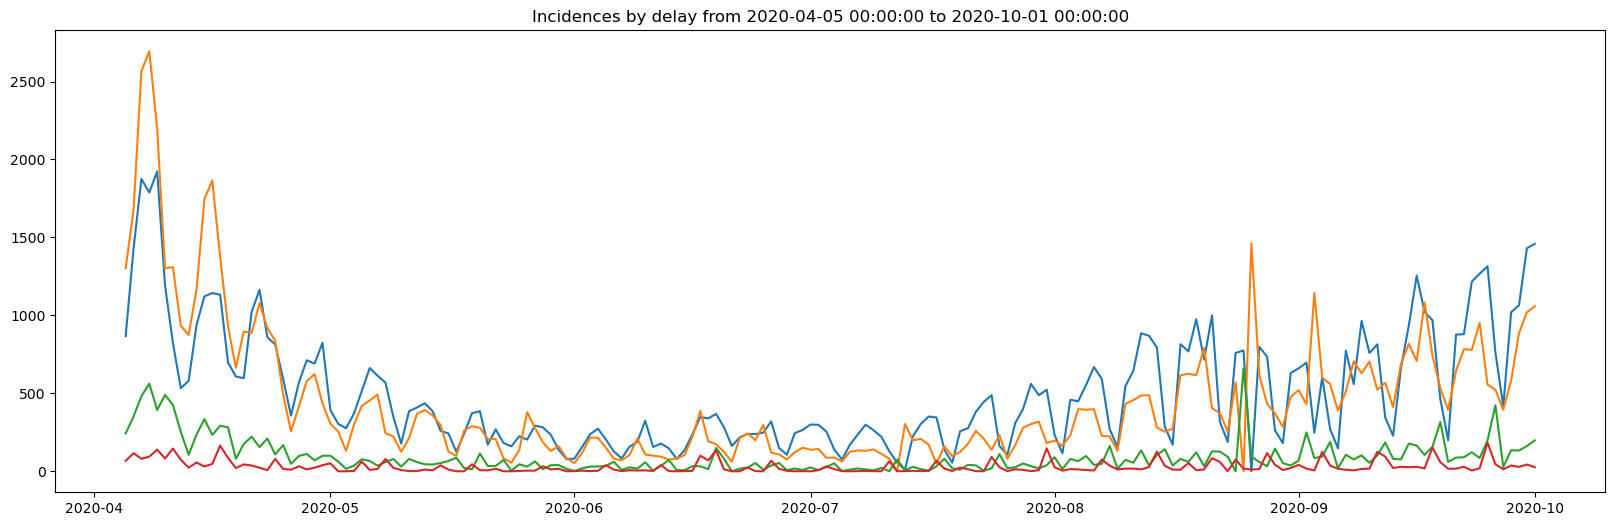

In [34]:
key = jrn.PRNGKey(34234234)

i_start = 0
np1 = 180
df = pd.read_csv("../../../data/processed/RKI_4day_rt.csv")
dates = pd.to_datetime(df.iloc[i_start : i_start + np1, 0])
y = jnp.asarray(df.iloc[i_start : i_start + np1, 1:].to_numpy())

plt.plot(dates, y)
plt.title(f"Incidences by delay from {dates[0]} to {dates[np1-1]}")
plt.show()

In [5]:
theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_M
    jnp.array([0.001**2, 0.1**2, 0.5**2, 0.01**2])
)
aux = (np1, 4)
intial_result = initial_theta(y, _model, theta_manual, aux, 10)
theta_0 = intial_result.x
intial_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.49885161921508
        x: [-8.511e+00 -7.691e+00  5.779e-01 -4.446e+00]
      nit: 43
      jac: [-9.022e-09 -3.544e-07 -6.164e-07  6.146e-07]
 hess_inv: [[ 1.862e+02  1.233e+01  1.569e-01 -2.226e+01]
            [ 1.233e+01  1.565e+02 -3.484e-02 -1.292e+01]
            [ 1.569e-01 -3.484e-02  3.612e+00 -1.287e-01]
            [-2.226e+01 -1.292e+01 -1.287e-01  2.062e+01]]
     nfev: 432
     njev: 48

In [6]:
key, subkey = jrn.split(key)
mle_result = mle_pgssm(y, _model, theta_0, aux, 10, 1000, subkey)
theta_hat = mle_result.x
mle_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.497867327367745
        x: [-8.511e+00 -7.691e+00  5.795e-01 -4.446e+00]
      nit: 3
      jac: [-1.442e-06 -8.462e-07 -1.144e-08 -1.484e-06]
 hess_inv: [[ 1.000e+00  8.639e-05  2.250e-02  1.960e-04]
            [ 8.639e-05  1.000e+00  1.332e-02  1.161e-04]
            [ 2.250e-02  1.332e-02  4.188e+00  2.981e-02]
            [ 1.960e-04  1.161e-04  2.981e-02  1.000e+00]]
     nfev: 36
     njev: 4

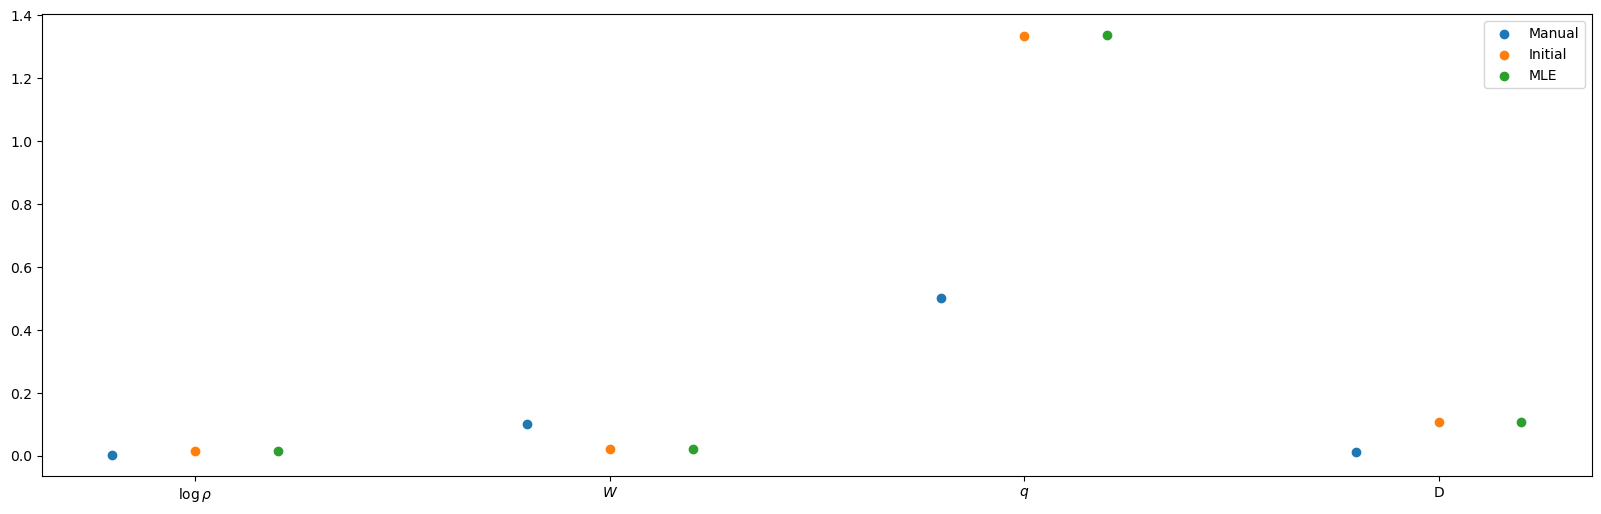

In [7]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta_0 / 2)
s_mle = jnp.exp(theta_hat / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D"])
plt.legend()
plt.show()

In [8]:
fitted_model = _model(theta_hat, aux)
proposal_la, info_la = LA(y, fitted_model, 10)
key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10, 1000, subkey
)
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y, fitted_model, proposal_meis.z, proposal_meis.Omega, 1000, subkey
)
ess_pct(lw)

Array(8.27997248, dtype=float64)

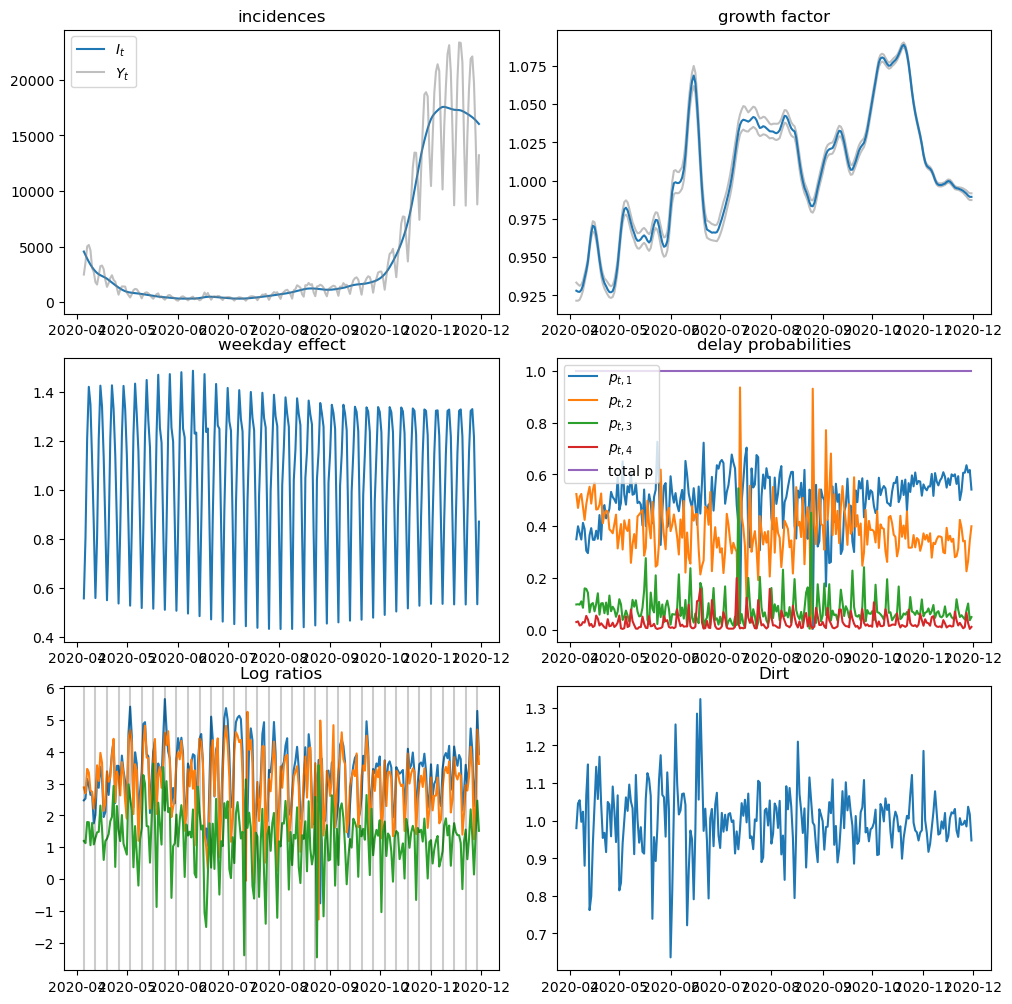

In [9]:
state_modes_meis = vmap(state_mode, (None, 0))(fitted_model, samples)
x_smooth = mc_integration(state_modes_meis, lw)
x_lower, x_mid, x_upper = prediction_percentiles(
    state_modes_meis, normalize_weights(lw), jnp.array([2.5, 50.0, 97.5]) / 100.0
)

# I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth = mc_integration(jnp.exp(state_modes_meis[:, :, 0]), lw)
rho_smooth = jnp.exp(x_smooth[:, 1])
D_smooth = jnp.exp(x_smooth[:, 2])
W_smooth = jnp.exp(x_smooth[:, 3])
log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
# axs[0].plot(dates, jnp.exp(x_lower[:, 0]), color="black", linestyle="dashed")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$", color="grey", alpha=0.5)
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_lower[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, jnp.exp(x_upper[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")

axs[3].set_title("delay probabilities")

axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)
plt.show()

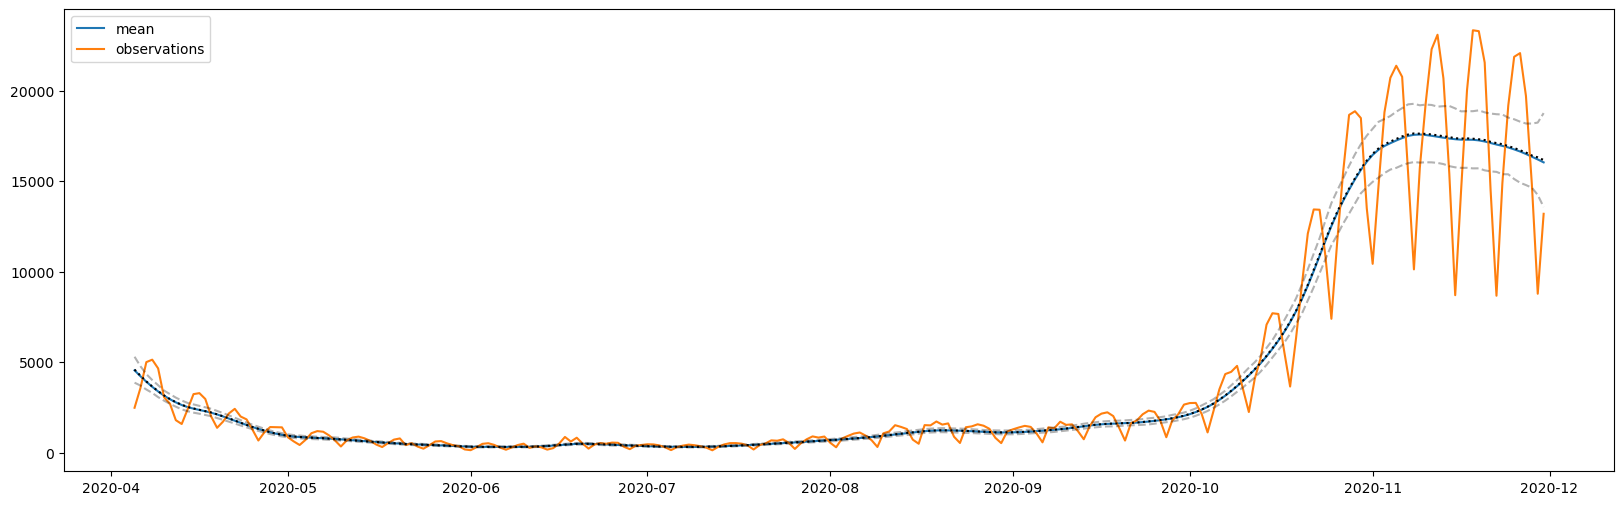

In [19]:
from isssm.importance_sampling import prediction


def f_I(x, s, y_prime):
    return jnp.exp(x[:, 0:1])


percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)
mean, sd, quantiles = prediction(
    f_I, y, proposal_meis, fitted_model, 1000, key, percentiles_of_interest
)
plt.plot(dates, mean, label="mean")
plt.plot(dates, y.sum(axis=-1), label="observations")
plt.plot(dates, quantiles[0], linestyle="dashed", color="black", alpha=0.3)
plt.plot(dates, quantiles[12], linestyle="dotted", color="black")
plt.plot(dates, quantiles[-1], linestyle="dashed", color="black", alpha=0.3)
plt.legend()
plt.show()

## Storing results

In [11]:
# theta
df_theta = pd.DataFrame.from_records(
    jnp.vstack([theta_manual, theta_0, theta_hat]),
    columns=["log rho", "W", "q", "M"],
    index=["manual", "initial", "MLE"],
)
df_theta.to_csv(
    "../../../data/results/4_showcase_model/thetas.csv", index_label="method"
)
df_theta

,log rho,W,q,M
manual,-13.815510557964274,-4.605170185988091,-1.3862943611198906,-9.210340371976182
initial,-8.510854898970004,-7.691462843622975,0.5779217399992015,-4.445763476758061
MLE,-8.510845242723423,-7.691457122484512,0.5795064679171656,-4.445750349834347


In [30]:
from isssm.importance_sampling import prediction
from jaxtyping import Float, Array

# predictions

# date / name / mean / sd / percentiles

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)

key, subkey_prediction = jrn.split(key)


def f_predict(x, s, y):
    probs = jnp.exp(to_log_probs(s[:, 1:]))
    return jnp.concatenate(
        [
            jnp.exp(x[:, 0:1]),  # I
            jnp.exp(x[:, 1:2]),  # rho
            jnp.exp(x[:, 2:3]),  # D
            jnp.exp(x[:, 3:4]),  # W
            probs,
        ],
        -1,
    )


def stacked_prediction(f):
    mean, sd, quantiles = prediction(
        f,
        y,
        proposal_meis,
        fitted_model,
        1000,
        subkey_prediction,
        percentiles_of_interest,
    )
    return jnp.vstack((mean[None], sd[None], quantiles))


jnp.save(
    "../../../data/results/4_showcase_model/predictions.npy",
    stacked_prediction(f_predict),
)